## TRANSFORMER: FIRST DRAFT

### IMPORTS

In [1]:
import sys
import os
from pathlib import Path

current_path = Path(os.getcwd())

project_root = current_path.parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Working in: {current_path}")
print(f"Root of the project: {project_root}")

try:
    import nuimages 
    import nuscenes
except ImportError as e:
    print(f"Error: {e}")

Working in: /root/nuscenes-devkit/python-sdk/main/notebooks
Root of the project: /root/nuscenes-devkit/python-sdk


In [ ]:
import argparse
import pickle
from nuscenes import NuScenes
import os
import json
from nuscenes.map_expansion.map_api import NuScenesMap

from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
import torch
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.eval.prediction.data_classes import Prediction

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.metrics import MinADEK, MinFDEK, RowMean
from nuscenes.prediction.models.backbone import ResNetBackbone

from matplotlib import pyplot as plt

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet

from torch.utils.data import Dataset, DataLoader
from nuscenes.prediction.models.mtp import MTPLoss

import torch.nn as nn

MINI wayformer a partir d'embeddings

Primer s'ha hagut de fer els embeddings i concatenarlos. 

In [ ]:
# shapes de entrada al Transformer (que prepararás después)
# bev_emb:      (batch_size, 1, D)
# agent_embs:   (batch_size, N_agents, D)
# lane_embs:    (batch_size, N_lanes, D)

# y luego los concatenas:
# tokens = torch.cat([bev_emb, agent_embs, lane_embs], dim=1)  # (B, T, D)


### agent embedding:

CADA AGENT TÉ AIXÒ: posición (x, y), velocidad, aceleración, heading (ángulo), tamaño (width, length),clase (car, pedestrian, bicycle…), historia pasada (opcional), estado actual (si está quieto o no, etc.)

amb una dimensionalidad podriem tenir un feature vector així: [x, y, vx, vy, ax, ay, heading_sin, heading_cos, width, length]


In [ ]:
def extract_agent_features(helper, instance_token, sample_token):
    ann = helper.get_sample_annotation(instance_token, sample_token)

    # Position
    x, y, _ = ann["translation"]

    # Velocity
    vx, vy = helper.get_velocity_for_agent(instance_token, sample_token)

    # Acceleration
    ax, ay = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Heading (convert quaternion → sin/cos)
    quat = ann["rotation"]  # [qw, qx, qy, qz]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # Size
    width, length, _ = ann["size"]

    # Feature vector
    features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

    return features  # shape (10,)


## PASSAR TOTS ELS AGENTS PER UN MLP PER TENIR AGENT EMBEDDING DE agent embedding (B, N_agents, D)
class AgentEncoder(nn.Module):
    def __init__(self, in_dim=10, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, agent_features):
        """
        agent_features: (B, N_agents, 10)
        returns: (B, N_agents, out_dim)
        """
        return self.mlp(agent_features)

MAX_AGENTS = 12  # como Waymo, puedes escoger 12–16

def build_agent_embeddings(helper, sample_token, agent_encoder, device):
    anns = helper.get_annotations_for_sample(sample_token)

    features = []

    for ann in anns:
        instance_token = ann["instance_token"]
        f = extract_agent_features(helper, instance_token, sample_token)
        features.append(f)

        if len(features) == MAX_AGENTS:
            break

    # Padding
    while len(features) < MAX_AGENTS:
        features.append(np.zeros(10, dtype=np.float32))

    features = torch.tensor(features, device=device)  # (MAX_AGENTS, 10)
    features = features.unsqueeze(0)  # (1, MAX_AGENTS, 10)

    # Agent Encoder
    with torch.no_grad():  # or leave gradients if end-to-end
        agent_emb = agent_encoder(features)  # (1, MAX_AGENTS, d_model)

    return agent_emb  # shape (1, N_agents, d_model)


### Lane embeddings

L'objectiu és donat un sample_token lane_emb: (1, N_lanes, d_model). Cada lane a nuscenes es un polyline ([(x1, y1), (x2, y2), ..., (xk, yk)])
cADA LANE TIENE Type,conexiones, direccion del trafico y curbatura

Pero la mínima base funcional para un Transformer es:

✔ samplear la polilínea
✔ convertir cada punto a un feature
✔ agregar todos los puntos para crear un embedding por lane

Obtenim les polylines més properes al agent

In [ ]:
def get_relevant_lanes(helper, agent_x, agent_y, max_lanes=8):
    """
    Returns up to max_lanes lane IDs near the agent.
    """
    lane_ids = helper.map_api.get_lane_ids_in_xy(agent_x, agent_y)

    # If too many lanes, keep closest N
    if len(lane_ids) > max_lanes:
        lane_ids = lane_ids[:max_lanes]

    return lane_ids


Treiem la polilínea de cada agent

In [ ]:
def get_lane_polyline(helper, lane_id):
    # returns Nx2 array with (x, y)
    poly = helper.map_api.get_lane_centerline(lane_id)[:, :2]
    return poly  # shape (K, 2)


Convertim cada polilínea en un conjunt de features (com es fa a implementacions com LaneGCN y Vectornet)
dx, dy                 → dirección del segmento
length                 → distancia
norm direction         → dx / length, dy / length
curvature              → change of angle (si queremos)


In [ ]:
import numpy as np

def polyline_to_features(poly):
    """
    poly: (K,2)
    returns features for each segment: (K-1, 5)
    """
    segments = []
    for i in range(len(poly) - 1):
        x1, y1 = poly[i]
        x2, y2 = poly[i+1]

        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx*dx + dy*dy) + 1e-6
        nx = dx / length
        ny = dy / length

        # Feature per segment
        feat = [dx, dy, length, nx, ny]
        segments.append(feat)

    return np.array(segments, dtype=np.float32)  # (K-1, 5)


Ara MLP com abans per fer el lane encoder. 

In [ ]:
class LaneSegmentEncoder(nn.Module):
    def __init__(self, in_dim=5, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, seg_features):
        """
        seg_features: (num_segments, in_dim)
        returns: (num_segments, out_dim)
        """
        return self.mlp(seg_features)


In [ ]:
def aggregate_lane_embedding(segment_embs):
    """
    segment_embs: (num_segments, d_model)
    returns a single lane embedding: (d_model,)
    """
    return segment_embs.mean(dim=0)  # or max(dim=0)[0]


In [ ]:
def build_lane_embedding(helper, lane_id, lane_encoder, device):
    # 1. Polyline
    poly = get_lane_polyline(helper, lane_id)  # (K,2)

    seg_feats = polyline_to_features(poly)     # (K-1, 5)
    seg_feats = torch.tensor(seg_feats, device=device)

    # 2. Encode each segment
    seg_embs = lane_encoder(seg_feats)         # (K-1, d_model)

    # 3. Aggregate segment embeddings
    lane_emb = seg_embs.mean(dim=0)            # (d_model,)

    return lane_emb


Hacemos embedings para todos los lanes

In [ ]:
MAX_LANES = 8

def build_lane_embeddings(helper, agent_x, agent_y, lane_encoder, device):
    lane_ids = get_relevant_lanes(helper, agent_x, agent_y, max_lanes=MAX_LANES)

    lane_embs = []
    for lane_id in lane_ids:
        emb = build_lane_embedding(helper, lane_id, lane_encoder, device)
        lane_embs.append(emb)

    # Padding
    while len(lane_embs) < MAX_LANES:
        lane_embs.append(torch.zeros(lane_embs[0].shape, device=device))

    lane_embs = torch.stack(lane_embs, dim=0)  # (MAX_LANES, d_model)
    lane_embs = lane_embs.unsqueeze(0)         # (1, MAX_LANES, d_model)

    return lane_embs


El resultado tendria que ser un sistema on el lane_emb :(1,N_lanes, d_model)

### Bird Eye View embedding

Aquest embedding hauria de ser un tensor que resumeixi tota la escena. bev_emb: (1, 1, d_model)

La imatge rasterizada en vista cenital ja està implementada a nuscnees: 

In [ ]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.301 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [ ]:
helper = PredictHelper(nuscenes)
static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())
# img = mtp_input_representation.make_input_representation(instance_token, sample_token)


La imatge que produeix el multicanal d'unes dimensions com: (3, 224, 224)    o (3, 500, 500)  según configuración
    

Això se li pasa a una resnet (cnn) treiem un embedding i el reduim a d_model i serà el primer token del transformer

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch


class BEVBackbone(nn.Module):
    def __init__(self, out_dim=128, arch="resnet18"):
        super().__init__()

        if arch == "resnet18":
            base = models.resnet18(weights=None)
            feat_dim = 512
        elif arch == "resnet50":
            base = models.resnet50(weights=None)
            feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")

        # Remove final FC layer, keep convolutional trunk
        self.cnn = nn.Sequential(*list(base.children())[:-1])  # output: (B, feat_dim, 1, 1)

        # MLP to project onto transformer dimension
        self.proj = nn.Linear(feat_dim, out_dim)

    def forward(self, bev_img):
        """
        bev_img: (B, C, H, W)
        returns: (B, out_dim)
        """
        x = self.cnn(bev_img)         # (B, feat_dim, 1, 1)
        x = x.view(x.size(0), -1)     # (B, feat_dim)
        x = self.proj(x)              # (B, out_dim)
        return x


In [ ]:
class BEVEncoder(nn.Module):
    def __init__(self, input_representation, d_model=128, arch="resnet18", device="cpu"):
        super().__init__()
        self.input_representation = input_representation
        self.device = device

        # CNN backbone to extract features
        self.backbone = BEVBackbone(out_dim=d_model, arch=arch).to(device)

    def forward(self, instance_token, sample_token):
        """
        Returns:
            bev_token: (1, 1, d_model)
        """

        # 1) Rasterize nuScenes BEV image
        img = self.input_representation.make_input_representation(
            instance_token, sample_token
        )   # numpy array (H, W, C)

        # 2) Convert → torch tensor
        bev_img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C,H,W)
        bev_img = bev_img.unsqueeze(0).to(self.device)                    # (1,C,H,W)

        # 3) Normalize (IMPORTANT — like ImageNet)
        bev_img = (bev_img - bev_img.mean()) / (bev_img.std() + 1e-6)

        # 4) Extract embedding using CNN backbone
        bev_emb = self.backbone(bev_img)   # (1, d_model)

        # 5) Convert to a single transformer token → (1,1,d_model)
        bev_token = bev_emb.unsqueeze(1)

        return bev_token


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bev_encoder = BEVEncoder(
    input_representation=mtp_input_representation,
    d_model=128,
    arch="resnet18",
    device=device
)

# OBTENER TOKEN PARA UN SAMPLE
# bev_token = bev_encoder(instance_token, sample_token)
# print(bev_token.shape)

# la sortida hauria de ser: torch.Size([1, 1, 128])



In [ ]:
def build_bev_embedding(self, instance_token, sample_token):
    
    # 1. Rasterize BEV image (you already do this)
    img = self.input_representation.make_input_representation(
        instance_token, sample_token
    )  # numpy array (H, W, C)

    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
    img = img.unsqueeze(0).to(self.device)  # (1, C, H, W)

    # 2. Backbone CNN → embedding
    bev_emb = self.bev_backbone(img)        # (1, d_model)

    # 3. Convert to transformer token
    bev_token = bev_emb.unsqueeze(1)        # (1, 1, d_model)

    return bev_token


### Transformer

Després només fa falta el model transformer i el head de predicció de trajectories. 

In [ ]:
import math
import torch
from torch import nn
from torch.nn import functional as F


class PositionalEncoding(nn.Module):
    """
    Standard sine-cosine positional encoding from the "Attention is All You Need" paper.
    Adds position information to each token in the sequence.
    """

    def __init__(self, d_model: int, max_len: int = 256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # shape -> (1, max_len, d_model) to broadcast over batch
        self.register_buffer("pe", pe.unsqueeze(0))  

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        # Add positional encoding to the input embeddings
        x = x + self.pe[:, :seq_len, :]
        return x


class TrajectoryTransformer(nn.Module):
    """
    Transformer-based trajectory prediction model.

    Inputs:
        - token_embeddings: (batch_size, seq_len, d_model)
          Sequence of tokens from:
            * 1 BEV embedding
            * N agent embeddings
            * M lane embeddings

    Outputs:
        - trajectories: (batch_size, num_modes, num_steps, 2)
        - mode_logits (optional): (batch_size, num_modes)
    """

    def __init__(
        self,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        num_modes: int = 1,
        num_steps: int = 12,
        use_mode_head: bool = True,
    ):
        super().__init__()

        self.d_model = d_model
        self.num_modes = num_modes
        self.num_steps = num_steps
        self.use_mode_head = use_mode_head

        # Positional encoding for the sequence tokens
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=256)

        # Transformer encoder (no decoder needed, we just encode the scene)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # input/output shape = (batch, seq, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # We will use the "scene token" representation to decode trajectories.
        # Typically we take the first token (e.g. BEV or a special [CLS]-like token).
        self.scene_pool = "first"  # could be 'mean' if you want average pooling

        # Head that maps the scene embedding to future trajectories
        # Output size = num_modes * num_steps * 2 (x, y)
        self.traj_head = nn.Linear(d_model, num_modes * num_steps * 2)

        # Optional mode classification head (for multi-modal prediction)
        if use_mode_head and num_modes > 1:
            self.mode_head = nn.Linear(d_model, num_modes)
        else:
            self.mode_head = None

    def _pool_scene_token(self, encoded_tokens: torch.Tensor) -> torch.Tensor:
        """
        encoded_tokens: (batch_size, seq_len, d_model)
        Returns:
            scene_emb: (batch_size, d_model)
        """
        if self.scene_pool == "first":
            # Take the first token (assumed to be the BEV / global context token)
            scene_emb = encoded_tokens[:, 0, :]
        elif self.scene_pool == "mean":
            scene_emb = encoded_tokens.mean(dim=1)
        else:
            raise ValueError(f"Unknown scene_pool mode: {self.scene_pool}")
        return scene_emb

    def forward(
        self,
        token_embeddings: torch.Tensor,
        src_key_padding_mask: torch.Tensor | None = None,
    ):
        """
        Args:
            token_embeddings: (batch_size, seq_len, d_model)
            src_key_padding_mask: optional boolean mask of shape (batch_size, seq_len)
                True for positions that should be masked (i.e., padding tokens).

        Returns:
            trajectories: (batch, num_modes, num_steps, 2)
            mode_logits (or None): (batch, num_modes)
        """

        # 1) Add positional encoding
        x = self.pos_encoder(token_embeddings)  # (B, T, D)

        # 2) Transformer encoder
        # If using src_key_padding_mask, it must be (B, T)
        encoded = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask,
        )  # (B, T, D)

        # 3) Pool scene representation (e.g. from first token)
        scene_emb = self._pool_scene_token(encoded)  # (B, D)

        # 4) Trajectory prediction head
        traj_flat = self.traj_head(scene_emb)  # (B, num_modes * num_steps * 2)
        trajectories = traj_flat.view(
            -1, self.num_modes, self.num_steps, 2
        )  # (B, M, T, 2)

        # 5) Optional mode logits for multi-modal weighting
        mode_logits = None
        if self.mode_head is not None:
            mode_logits = self.mode_head(scene_emb)  # (B, num_modes)

        return trajectories, mode_logits


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiModalTrajectoryLoss(nn.Module):
    """
    Multimodal loss for trajectory prediction:
      - Picks the best mode based on L2 distance (ADE)
      - Applies regression loss on that mode (Smooth L1)
      - Applies cross entropy on mode logits
    """

    def __init__(self, regression_weight=1.0, classification_weight=1.0, vel_weight=0.5, acc_weight=0.1, fde_weight=1.0, dt=0.5):
        super().__init__()
        self.reg_weight = regression_weight
        self.cls_weight = classification_weight
        self.vel_weight = vel_weight
        self.acc_weight = acc_weight
        self.fde_weight = fde_weight
        self.dt = dt
        self.reg_loss_fn = nn.SmoothL1Loss()

    def forward(self, trajectories, mode_logits, gt_future):
      B, M, T, _ = trajectories.shape

      diff = trajectories - gt_future.unsqueeze(1)
      l2 = torch.norm(diff, dim=-1)
      ade = l2.mean(dim=-1)

      best_mode = ade.argmin(dim=1)
      best_traj = trajectories[torch.arange(B), best_mode]

      # Position loss
      pos_loss = self.reg_loss_fn(best_traj, gt_future)

      # Velocity loss
      pred_v = (best_traj[:, 1:] - best_traj[:, :-1]) / self.dt
      gt_v   = (gt_future[:, 1:] - gt_future[:, :-1]) / self.dt
      vel_loss = self.reg_loss_fn(pred_v, gt_v)

      # Acceleration loss
      pred_a = (pred_v[:, 1:] - pred_v[:, :-1]) / self.dt
      gt_a   = (gt_v[:, 1:] - gt_v[:, :-1]) / self.dt
      acc_loss = self.reg_loss_fn(pred_a, gt_a)

      pred_final = best_traj[:, -1]
      gt_final   = gt_future[:, -1]
      
      fde_loss = self.reg_loss_fn(pred_final, gt_final)

      reg_loss = (
          pos_loss
          + self.vel_weight * vel_loss
          + self.acc_weight * acc_loss
          + self.fde_weight * fde_loss
      )

      cls_loss = F.cross_entropy(mode_logits, best_mode)

      total_loss = self.reg_weight * reg_loss + self.cls_weight * cls_loss + self.fde_weight * fde_loss

      return (
          total_loss,
          pos_loss.detach(),
          vel_loss.detach(),
          acc_loss.detach(),
          cls_loss.detach(),
          fde_loss.detach(),
          best_mode
      )


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pyquaternion import Quaternion

class NuScenesTransformerDataset(Dataset):
    def __init__(self, helper, split_name='train_mini', max_agents=12, max_lanes=8):
        self.helper = helper
        self.split_name = split_name
        self.max_agents = max_agents
        self.max_lanes = max_lanes
        
        # Obtener lista de tokens del split correspondiente
        self.token_list = get_prediction_challenge_split(split_name, dataroot=helper.data.dataroot)
        
        # Instancias necesarias para rasterizar (definidas en tu notebook)
        self.static_rasterizer = StaticLayerRasterizer(helper)
        self.agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
        self.input_rep = InputRepresentation(self.static_rasterizer, self.agent_rasterizer, Rasterizer())

    def __len__(self):
        return len(self.token_list)

    def global_to_local(self, origin_translation, origin_rotation, points_global):
        """Transforma puntos globales a coordenadas locales del agente."""
        # points_global: (N, 2) o (2,)
        points_global = np.array(points_global)
        if points_global.ndim == 1:
            points_global = points_global[None, :]
            
        # 1. Traslación
        points_centered = points_global - origin_translation[:2]
        
        # 2. Rotación (Inversa del cuaternión del agente)
        # Nota: Trabajamos en 2D, así que rotamos sobre Z.
        q = Quaternion(origin_rotation)
        # La inversa deshace la rotación global para alinear con el eje X local
        q_inv = q.inverse
        
        points_local = []
        for p in points_centered:
            # Añadir z=0 para la rotación
            p_3d = np.array([p[0], p[1], 0.0])
            p_rot = q_inv.rotate(p_3d)
            points_local.append(p_rot[:2])
            
        return np.array(points_local, dtype=np.float32)

    def rotate_vector(self, vector, origin_rotation):
        """Rota un vector 2D (vx, vy) al frame local deshaciendo la rotación global del ego."""
        # vector: (2,)
        # origin_rotation: quaternion del ego (global)
        q = Quaternion(origin_rotation)
        q_inv = q.inverse # Inversa para pasar de Global a Local
        
        v_3d = np.array([vector[0], vector[1], 0.0])
        v_rot = q_inv.rotate(v_3d)
        return v_rot[:2]

    def __getitem__(self, idx):
        instance_token, sample_token = self.token_list[idx].split("_")
        
        # 1. BEV IMAGE (Igual)
        img_arr = self.input_rep.make_input_representation(instance_token, sample_token)
        img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
        img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)

        # 2. AGENT FEATURES (¡CORREGIDO!)
        anns = self.helper.get_annotations_for_sample(sample_token)
        target_ann = self.helper.get_sample_annotation(instance_token, sample_token)
        
        # Referencia del Ego (Target)
        ego_trans = target_ann['translation'] # Global
        ego_rot = target_ann['rotation']      # Global quaternion
        ego_yaw = Quaternion(ego_rot).yaw_pitch_roll[0]

        agent_feats_list = []
        
        # Lista de candidatos: Primero el Ego, luego los vecinos
        candidates = [target_ann] + [a for a in anns if a['instance_token'] != instance_token]
        candidates = candidates[:self.max_agents] # Recortar si hay muchos

        for ann in candidates:
            # A. Extraer datos crudos globales
            raw = extract_agent_features_dict(self.helper, ann['instance_token'], sample_token)
            
            # B. Transformar Posición (Global -> Local)
            # Esto pone al ego en (0,0) y a los vecinos en su posición relativa
            local_pos = self.global_to_local(ego_trans, ego_rot, raw['pos'])[0] 
            
            # C. Transformar Velocidad y Aceleración (Rotación)
            # Esto es clave: Si el ego va al Norte y el vecino al Oeste, 
            # en local el vecino se mueve a la izquierda.
            local_vel = self.rotate_vector(raw['vel'], ego_rot)
            local_acc = self.rotate_vector(raw['acc'], ego_rot)
            
            # D. Transformar Yaw (Relativo)
            # El ángulo del vecino relativo a hacia donde mira el ego
            yaw_rel = raw['yaw'] - ego_yaw
            
            # Construir vector final (10 dim)
            # [x, y, vx, vy, ax, ay, sin, cos, w, l]
            feat_vec = np.array([
                local_pos[0], local_pos[1],
                local_vel[0], local_vel[1],
                local_acc[0], local_acc[1],
                np.sin(yaw_rel), np.cos(yaw_rel),
                raw['size'][0], raw['size'][1]
            ], dtype=np.float32)
            
            agent_feats_list.append(feat_vec)

        # 3. MÁSCARA DE PADDING (¡CRÍTICO!)
        # True = Padding (Ignorar), False = Real (Atender)
        # Inicializamos todo a True (ignorar)
        agent_mask = torch.ones(self.max_agents, dtype=torch.bool)
        # Marcamos como False (Real) los que acabamos de añadir
        agent_mask[:len(agent_feats_list)] = False
        
        # Rellenar features con ceros
        while len(agent_feats_list) < self.max_agents:
            agent_feats_list.append(np.zeros(10, dtype=np.float32))
            
        agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)

        # 4. GROUND TRUTH (Igual, ya estaba bien)
        gt_global = self.helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
        gt_local = self.global_to_local(ego_trans, ego_rot, gt_global)
        
        # Padding simple para GT si es corto
        T = 12
        if gt_local.shape[0] < T:
             pad = np.zeros((T - gt_local.shape[0], 2))
             if len(gt_local) > 0: # Repetir ultima posicion
                 pad[:] = gt_local[-1]
             gt_local = np.concatenate([gt_local, pad], axis=0)
        
        gt_tensor = torch.tensor(gt_local, dtype=torch.float32)

        return {
            "bev": img_tensor,
            "agents": agent_tensor,
            "agent_mask": agent_mask, # <--- Pasamos la máscara
            "gt": gt_tensor,
            "tokens": (instance_token, sample_token)
        }

In [ ]:
class WayformerModel(torch.nn.Module):
    def __init__(self, device, d_model=128, num_modes=3):
        super().__init__()
        self.d_model = d_model
        self.device = device
        
        # 1. Encoders (De tu notebook)
        # Nota: BEVEncoder interna usa una CNN. 
        # Modificamos BEVEncoder ligeramente para aceptar tensores directos, no tokens
        self.bev_backbone = BEVBackbone(out_dim=d_model, arch="resnet18") 
        self.agent_encoder = AgentEncoder(in_dim=10, out_dim=d_model)
        self.lane_encoder = LaneSegmentEncoder(in_dim=5, out_dim=d_model)
        # self.lane_encoder = LaneEncoder(...) # Si usas lanes
        
        # 2. Transformer
        self.transformer = TrajectoryTransformer(
            d_model=d_model,
            num_modes=num_modes,
            num_steps=12,
            use_mode_head=True
        )

    def forward(self, bev_img, agent_features, agent_mask=None):
        """
        agent_mask: (B, N_agents) BoolTensor. True donde es padding.
        """
        B = bev_img.size(0)

        # A. BEV Embedding
        bev_emb = self.bev_backbone(bev_img) 
        bev_token = bev_emb.unsqueeze(1) # (B, 1, d_model)
        
        # La máscara del BEV es siempre False (siempre atender a la imagen)
        bev_mask = torch.zeros((B, 1), dtype=torch.bool, device=self.device)

        # B. Agentes Embedding
        agent_emb = self.agent_encoder(agent_features) # (B, N, d_model)

        # C. Fusión de Tokens
        tokens = torch.cat([bev_token, agent_emb], dim=1)
        
        # D. Fusión de Máscaras
        if agent_mask is None: # Seguridad
            agent_mask = torch.zeros((B, agent_features.size(1)), dtype=torch.bool, device=self.device)
            
        # Concatenamos: [Mascara BEV, Mascara Agentes]
        src_key_padding_mask = torch.cat([bev_mask, agent_mask], dim=1)

        # E. Transformer
        # Pasa la máscara. El transformer pondrá atención -infinito a los True.
        trajectories, mode_logits = self.transformer(
            tokens, 
            src_key_padding_mask=src_key_padding_mask
        )
        
        return trajectories, mode_logits

In [ ]:
import numpy as np
from pyquaternion import Quaternion

def extract_agent_features(helper, instance_token, sample_token):
    ann = helper.get_sample_annotation(instance_token, sample_token)

    # 1. Position
    x, y, _ = ann["translation"]

    # 2. Heading (Yaw)
    quat = ann["rotation"]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # 3. Velocity (Scalar -> Vector)
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0 # Manejo de NaNs crucial
    
    # Proyectamos la velocidad en X e Y usando el ángulo del coche
    vx = speed * cos_yaw
    vy = speed * sin_yaw

    # 4. Acceleration (Scalar -> Vector)
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    
    ax = accel * cos_yaw
    ay = accel * sin_yaw

    # 5. Size
    width, length, _ = ann["size"]

    # Feature vector final
    features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

    return features

def extract_agent_features_dict(helper, instance_token, sample_token):
    """
    Extrae datos crudos en coordenadas GLOBALES.
    """
    ann = helper.get_sample_annotation(instance_token, sample_token)
    
    # Velocidad Global
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0
    
    # Aceleración Global
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    
    # Orientación Global
    yaw = Quaternion(ann["rotation"]).yaw_pitch_roll[0]
    
    # Vectorizar velocidad globalmente
    vx = speed * np.cos(yaw)
    vy = speed * np.sin(yaw)
    ax = accel * np.cos(yaw)
    ay = accel * np.sin(yaw)

    return {
        'pos': ann['translation'][:2],  # Global x,y
        'vel': np.array([vx, vy]),      # Global vx,vy
        'acc': np.array([ax, ay]),      # Global ax,ay
        'yaw': yaw,                     # Global yaw
        'size': ann['size'][:2],        # w, l
        'rotation': ann['rotation']     # quaternion
    }

BATCH_SIZE = 8

# Re-instanciar para que los workers cojan la nueva función
train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train')
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    drop_last=True
)


In [ ]:
# ignore the warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# --- CONFIGURACIÓN ---
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 25
NUM_MODES = 3

# # 1. Preparar Dataset y Dataloader
# train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train') # Usa 'train' para el full
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True, 
#     num_workers=4,
#     drop_last=True
# )

# 2. Instanciar Modelo y Loss
model = WayformerModel(device=DEVICE, d_model=128, num_modes=NUM_MODES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Usamos tu Loss personalizada (MTP Loss + Lane deviation si quisieras)
# Nota: Pasamos helper=None para simplificar ahora, si quieres LaneLoss pásale el helper
# criterion = MTPLoss(
#     num_modes=NUM_MODES, 
#     regression_loss_weight=1.0, 
#     angle_threshold_degrees=10.0,
#     lane_loss_weight=0.0, # Desactivado por ahora para testear training loop
#     helper=None
# )
criterion = MultiModalTrajectoryLoss(
    regression_weight=1.0,
    classification_weight=1.0,
    vel_weight=0.5,
    acc_weight=0.1,
    dt=0.5,
    fde_weight=1.0
)

# 3. Loop de Entrenamiento
print(f"🚀 Iniciando entrenamiento en {DEVICE}...")
model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    
    for i, batch in tqdm(enumerate(train_loader)):
        # 1. Mover datos a GPU
        bev_img = batch['bev'].to(DEVICE)
        agent_feats = batch['agents'].to(DEVICE)
        gt_future = batch['gt'].to(DEVICE) # Shape: (B, 12, 2)
        
        # 2. Forward
        optimizer.zero_grad()
        
        # Obtenemos predicciones limpias
        # preds: (B, Modes, 12, 2)
        # mode_logits: (B, Modes)
        # En el loop:
        agent_mask = batch['agent_mask'].to(DEVICE)

        preds, mode_logits = model(bev_img, agent_feats, agent_mask=agent_mask)
        
        # --- CORRECCIÓN AQUÍ ---
        # No aplanes ni concatenes nada. 
        # La Loss moderna sabe manejar los tensores separados.
        
        # Pasamos los 3 argumentos que pide MultiModalTrajectoryLoss
        # Nota: No hace falta hacer gt_future.unsqueeze(1) aquí porque la loss ya lo hace dentro
        loss, reg_loss, vel_loss, acc_loss, cls_loss, fde_loss, _ = criterion(preds, mode_logits, gt_future)
        
        # 3. Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}] Total: {loss.item():.4f} | Reg: {reg_loss.item():.4f} | Cls: {cls_loss.item():.4f} | Vel: {vel_loss.item():.4f} | Acc: {acc_loss.item():.4f} | FDE: {fde_loss.item():.4f}")

    print(f"✅ Epoch {epoch+1} completada. Loss media: {total_loss/len(train_loader):.4f}")

🚀 Iniciando entrenamiento en cuda...


2it [00:05,  2.14s/it]

Epoch [1/25] Step [0] Total: 75.1228 | Reg: 15.2622 | Cls: 1.1596 | Vel: 5.0871 | Acc: 5.7976 | FDE: 27.7888


12it [00:08,  2.71it/s]

Epoch [1/25] Step [10] Total: 61.8169 | Reg: 13.2178 | Cls: 0.1893 | Vel: 4.1430 | Acc: 3.6435 | FDE: 22.9870


21it [00:14,  1.43it/s]

Epoch [1/25] Step [20] Total: 79.9858 | Reg: 17.0994 | Cls: 0.1272 | Vel: 4.8921 | Acc: 3.1122 | FDE: 30.0009


32it [00:18,  2.97it/s]

Epoch [1/25] Step [30] Total: 47.3338 | Reg: 10.7009 | Cls: 0.0952 | Vel: 3.1395 | Acc: 2.7314 | FDE: 17.3474


42it [00:24,  1.70it/s]

Epoch [1/25] Step [40] Total: 49.2561 | Reg: 10.8502 | Cls: 0.0998 | Vel: 3.2691 | Acc: 2.6002 | FDE: 18.2058


52it [00:29,  2.93it/s]

Epoch [1/25] Step [50] Total: 64.6333 | Reg: 13.8908 | Cls: 0.0817 | Vel: 4.1063 | Acc: 2.2218 | FDE: 24.1927


62it [00:34,  1.95it/s]

Epoch [1/25] Step [60] Total: 56.3199 | Reg: 12.3924 | Cls: 0.0714 | Vel: 3.7250 | Acc: 2.1106 | FDE: 20.8912


72it [00:39,  2.75it/s]

Epoch [1/25] Step [70] Total: 43.5635 | Reg: 9.7039 | Cls: 0.0690 | Vel: 3.0598 | Acc: 2.4567 | FDE: 16.0075


81it [00:44,  1.52it/s]

Epoch [1/25] Step [80] Total: 65.6180 | Reg: 13.9934 | Cls: 0.0564 | Vel: 4.1313 | Acc: 1.9876 | FDE: 24.6519


92it [00:49,  1.88it/s]

Epoch [1/25] Step [90] Total: 66.3720 | Reg: 14.3501 | Cls: 0.0519 | Vel: 4.2156 | Acc: 1.9839 | FDE: 24.8319
✅ Epoch 1 completada. Loss media: 60.8240



2it [00:02,  1.17s/it]

Epoch [2/25] Step [0] Total: 54.5984 | Reg: 11.8817 | Cls: 0.0483 | Vel: 3.4819 | Acc: 1.8964 | FDE: 20.3689


12it [00:07,  2.61it/s]

Epoch [2/25] Step [10] Total: 72.6954 | Reg: 15.6506 | Cls: 0.0542 | Vel: 4.6805 | Acc: 2.2552 | FDE: 27.2124


22it [00:13,  1.73it/s]

Epoch [2/25] Step [20] Total: 62.1164 | Reg: 13.4680 | Cls: 0.0427 | Vel: 3.9574 | Acc: 2.0822 | FDE: 23.2094


32it [00:18,  2.86it/s]

Epoch [2/25] Step [30] Total: 51.1378 | Reg: 11.1637 | Cls: 0.0393 | Vel: 3.3280 | Acc: 1.9193 | FDE: 19.0395


42it [00:23,  1.86it/s]

Epoch [2/25] Step [40] Total: 75.1017 | Reg: 16.8361 | Cls: 0.0363 | Vel: 4.6487 | Acc: 2.0142 | FDE: 27.8518


52it [00:28,  3.08it/s]

Epoch [2/25] Step [50] Total: 65.0168 | Reg: 14.3712 | Cls: 0.0298 | Vel: 4.1642 | Acc: 1.8785 | FDE: 24.1730


62it [00:34,  1.80it/s]

Epoch [2/25] Step [60] Total: 56.4858 | Reg: 12.1175 | Cls: 0.0371 | Vel: 3.6693 | Acc: 2.0722 | FDE: 21.1447


72it [00:38,  3.12it/s]

Epoch [2/25] Step [70] Total: 59.3667 | Reg: 13.2087 | Cls: 0.0293 | Vel: 3.8576 | Acc: 1.8340 | FDE: 22.0083


82it [00:43,  1.75it/s]

Epoch [2/25] Step [80] Total: 66.1778 | Reg: 14.9315 | Cls: 0.0309 | Vel: 4.1845 | Acc: 1.9841 | FDE: 24.4624


92it [00:48,  1.91it/s]

Epoch [2/25] Step [90] Total: 54.8435 | Reg: 11.8712 | Cls: 0.0278 | Vel: 3.6034 | Acc: 1.9540 | FDE: 20.4737
✅ Epoch 2 completada. Loss media: 57.6834



2it [00:02,  1.25s/it]

Epoch [3/25] Step [0] Total: 48.0744 | Reg: 10.2528 | Cls: 0.0269 | Vel: 3.2666 | Acc: 1.8594 | FDE: 17.9877


12it [00:07,  2.91it/s]

Epoch [3/25] Step [10] Total: 48.7224 | Reg: 10.5334 | Cls: 0.0247 | Vel: 3.3363 | Acc: 2.0045 | FDE: 18.1478


22it [00:12,  1.82it/s]

Epoch [3/25] Step [20] Total: 46.5124 | Reg: 10.0396 | Cls: 0.0237 | Vel: 3.1370 | Acc: 1.9249 | FDE: 17.3441


32it [00:17,  2.96it/s]

Epoch [3/25] Step [30] Total: 68.6915 | Reg: 14.9387 | Cls: 0.0263 | Vel: 4.3780 | Acc: 2.1796 | FDE: 25.6597


42it [00:23,  1.90it/s]

Epoch [3/25] Step [40] Total: 55.3007 | Reg: 11.8878 | Cls: 0.0217 | Vel: 3.7880 | Acc: 2.0153 | FDE: 20.6478


52it [00:27,  2.94it/s]

Epoch [3/25] Step [50] Total: 48.5793 | Reg: 10.7179 | Cls: 0.0181 | Vel: 3.2862 | Acc: 2.0808 | FDE: 17.9960


62it [00:33,  1.93it/s]

Epoch [3/25] Step [60] Total: 75.4433 | Reg: 16.4820 | Cls: 0.0237 | Vel: 4.7066 | Acc: 2.2044 | FDE: 28.1819


72it [00:37,  3.23it/s]

Epoch [3/25] Step [70] Total: 75.4369 | Reg: 16.8464 | Cls: 0.0204 | Vel: 4.8249 | Acc: 1.9072 | FDE: 27.9834


82it [00:42,  1.89it/s]

Epoch [3/25] Step [80] Total: 36.4625 | Reg: 8.1673 | Cls: 0.6196 | Vel: 2.5793 | Acc: 1.9017 | FDE: 13.0978


92it [00:47,  1.95it/s]

Epoch [3/25] Step [90] Total: 34.7199 | Reg: 7.8207 | Cls: 0.0190 | Vel: 2.5709 | Acc: 1.9172 | FDE: 12.7015
✅ Epoch 3 completada. Loss media: 55.9626



2it [00:02,  1.23s/it]

Epoch [4/25] Step [0] Total: 70.0575 | Reg: 15.3136 | Cls: 0.0194 | Vel: 4.5463 | Acc: 1.9543 | FDE: 26.1279


12it [00:07,  2.93it/s]

Epoch [4/25] Step [10] Total: 71.6243 | Reg: 15.3648 | Cls: 0.0136 | Vel: 4.5030 | Acc: 1.8807 | FDE: 26.9031


21it [00:12,  1.45it/s]

Epoch [4/25] Step [20] Total: 42.4644 | Reg: 9.5216 | Cls: 0.6660 | Vel: 2.9039 | Acc: 1.8866 | FDE: 15.3181


32it [00:17,  2.88it/s]

Epoch [4/25] Step [30] Total: 37.0894 | Reg: 7.9843 | Cls: 0.0144 | Vel: 2.5947 | Acc: 1.7288 | FDE: 13.8103


42it [00:23,  1.80it/s]

Epoch [4/25] Step [40] Total: 49.0514 | Reg: 10.3268 | Cls: 0.0158 | Vel: 3.4366 | Acc: 2.0559 | FDE: 18.3925


51it [00:27,  2.34it/s]

Epoch [4/25] Step [50] Total: 54.7256 | Reg: 12.0586 | Cls: 0.0153 | Vel: 3.7159 | Acc: 2.4530 | FDE: 20.2742


62it [00:33,  1.82it/s]

Epoch [4/25] Step [60] Total: 58.7459 | Reg: 12.6575 | Cls: 0.0154 | Vel: 3.9188 | Acc: 1.9266 | FDE: 21.9605


72it [00:37,  2.97it/s]

Epoch [4/25] Step [70] Total: 61.7878 | Reg: 13.4173 | Cls: 0.0147 | Vel: 3.9688 | Acc: 1.7464 | FDE: 23.0984


82it [00:43,  1.98it/s]

Epoch [4/25] Step [80] Total: 55.5481 | Reg: 11.9408 | Cls: 0.0144 | Vel: 3.6888 | Acc: 1.8526 | FDE: 20.7816


92it [00:47,  1.92it/s]

Epoch [4/25] Step [90] Total: 50.5171 | Reg: 11.3615 | Cls: 0.5845 | Vel: 3.3330 | Acc: 1.8457 | FDE: 18.3600
✅ Epoch 4 completada. Loss media: 54.0323



2it [00:02,  1.22s/it]

Epoch [5/25] Step [0] Total: 54.3544 | Reg: 11.5305 | Cls: 0.0132 | Vel: 3.7152 | Acc: 2.0820 | FDE: 20.3725


12it [00:07,  2.90it/s]

Epoch [5/25] Step [10] Total: 38.1045 | Reg: 8.6571 | Cls: 0.0142 | Vel: 2.7157 | Acc: 1.7836 | FDE: 13.9485


22it [00:12,  1.85it/s]

Epoch [5/25] Step [20] Total: 44.6281 | Reg: 9.4117 | Cls: 0.0126 | Vel: 3.1480 | Acc: 1.8021 | FDE: 16.7248


32it [00:17,  3.02it/s]

Epoch [5/25] Step [30] Total: 36.7876 | Reg: 8.2442 | Cls: 0.0137 | Vel: 2.7218 | Acc: 1.6987 | FDE: 13.4995


42it [00:22,  2.00it/s]

Epoch [5/25] Step [40] Total: 50.6822 | Reg: 10.7354 | Cls: 0.0122 | Vel: 3.3643 | Acc: 1.7657 | FDE: 19.0379


52it [00:27,  2.72it/s]

Epoch [5/25] Step [50] Total: 48.0647 | Reg: 10.4806 | Cls: 0.0153 | Vel: 3.3267 | Acc: 2.0858 | FDE: 17.8484


62it [00:33,  1.91it/s]

Epoch [5/25] Step [60] Total: 46.7121 | Reg: 10.0910 | Cls: 0.0159 | Vel: 3.1573 | Acc: 1.7665 | FDE: 17.4250


72it [00:37,  2.99it/s]

Epoch [5/25] Step [70] Total: 41.1588 | Reg: 8.5754 | Cls: 0.0135 | Vel: 2.9158 | Acc: 1.8055 | FDE: 15.4657


81it [00:42,  1.54it/s]

Epoch [5/25] Step [80] Total: 40.7329 | Reg: 8.6725 | Cls: 0.0179 | Vel: 2.9652 | Acc: 1.8724 | FDE: 15.1863


92it [00:47,  1.94it/s]

Epoch [5/25] Step [90] Total: 31.1693 | Reg: 6.8392 | Cls: 0.0197 | Vel: 2.4008 | Acc: 1.8066 | FDE: 11.4647
✅ Epoch 5 completada. Loss media: 52.0970



2it [00:02,  1.24s/it]

Epoch [6/25] Step [0] Total: 58.4316 | Reg: 12.0642 | Cls: 0.0189 | Vel: 3.9155 | Acc: 1.9380 | FDE: 22.0985


12it [00:07,  2.90it/s]

Epoch [6/25] Step [10] Total: 66.5816 | Reg: 14.4418 | Cls: 0.0169 | Vel: 4.3977 | Acc: 2.0176 | FDE: 24.8611


22it [00:12,  1.69it/s]

Epoch [6/25] Step [20] Total: 49.5837 | Reg: 11.2351 | Cls: 0.0174 | Vel: 3.3405 | Acc: 2.0068 | FDE: 18.2302


31it [00:17,  2.42it/s]

Epoch [6/25] Step [30] Total: 40.0870 | Reg: 8.7502 | Cls: 0.4801 | Vel: 2.7773 | Acc: 1.6221 | FDE: 14.6529


42it [00:23,  1.75it/s]

Epoch [6/25] Step [40] Total: 49.6447 | Reg: 10.7341 | Cls: 0.0194 | Vel: 3.3345 | Acc: 1.8623 | FDE: 18.5188


52it [00:27,  2.82it/s]

Epoch [6/25] Step [50] Total: 44.6314 | Reg: 9.9801 | Cls: 0.0244 | Vel: 3.1451 | Acc: 1.8713 | FDE: 16.4336


62it [00:33,  1.78it/s]

Epoch [6/25] Step [60] Total: 29.2966 | Reg: 6.5235 | Cls: 0.0214 | Vel: 2.3080 | Acc: 1.7314 | FDE: 10.7123


72it [00:38,  3.01it/s]

Epoch [6/25] Step [70] Total: 55.9731 | Reg: 11.7567 | Cls: 0.0306 | Vel: 3.7370 | Acc: 1.8860 | FDE: 21.0643


82it [00:43,  1.83it/s]

Epoch [6/25] Step [80] Total: 49.5901 | Reg: 10.4302 | Cls: 0.0222 | Vel: 3.4717 | Acc: 2.0039 | FDE: 18.6007


92it [00:48,  1.90it/s]

Epoch [6/25] Step [90] Total: 24.1118 | Reg: 4.9048 | Cls: 0.0221 | Vel: 1.9424 | Acc: 1.7651 | FDE: 9.0186
✅ Epoch 6 completada. Loss media: 50.1518



2it [00:03,  1.28s/it]

Epoch [7/25] Step [0] Total: 39.7756 | Reg: 8.4193 | Cls: 0.0222 | Vel: 2.8904 | Acc: 1.9625 | FDE: 14.8463


12it [00:07,  2.87it/s]

Epoch [7/25] Step [10] Total: 39.3983 | Reg: 8.8324 | Cls: 0.0242 | Vel: 2.9361 | Acc: 1.8053 | FDE: 14.4466


22it [00:13,  1.87it/s]

Epoch [7/25] Step [20] Total: 31.2582 | Reg: 6.7210 | Cls: 0.0268 | Vel: 2.3922 | Acc: 1.8570 | FDE: 11.5643


32it [00:17,  3.04it/s]

Epoch [7/25] Step [30] Total: 45.3059 | Reg: 9.5221 | Cls: 0.0232 | Vel: 3.1217 | Acc: 2.0530 | FDE: 16.9972


41it [00:22,  1.58it/s]

Epoch [7/25] Step [40] Total: 41.5628 | Reg: 8.8362 | Cls: 0.0230 | Vel: 2.9476 | Acc: 1.9076 | FDE: 15.5195


52it [00:27,  2.93it/s]

Epoch [7/25] Step [50] Total: 33.4379 | Reg: 7.0727 | Cls: 0.0203 | Vel: 2.4722 | Acc: 1.8918 | FDE: 12.4598


62it [00:33,  2.00it/s]

Epoch [7/25] Step [60] Total: 43.1496 | Reg: 8.9950 | Cls: 0.0276 | Vel: 3.0296 | Acc: 1.8758 | FDE: 16.2123


72it [00:37,  2.96it/s]

Epoch [7/25] Step [70] Total: 44.9498 | Reg: 8.8444 | Cls: 0.3961 | Vel: 3.0950 | Acc: 1.7973 | FDE: 16.9910


82it [00:43,  1.76it/s]

Epoch [7/25] Step [80] Total: 24.4137 | Reg: 5.2326 | Cls: 0.4134 | Vel: 1.8755 | Acc: 1.7108 | FDE: 8.8295


92it [00:47,  1.94it/s]

Epoch [7/25] Step [90] Total: 33.8027 | Reg: 7.2058 | Cls: 0.0374 | Vel: 2.7485 | Acc: 1.9926 | FDE: 12.4930
✅ Epoch 7 completada. Loss media: 48.1091



2it [00:02,  1.16s/it]

Epoch [8/25] Step [0] Total: 43.3407 | Reg: 9.1526 | Cls: 0.3200 | Vel: 2.9244 | Acc: 1.8536 | FDE: 16.1103


11it [00:07,  2.19it/s]

Epoch [8/25] Step [10] Total: 57.4767 | Reg: 11.9459 | Cls: 0.0364 | Vel: 3.8132 | Acc: 1.9860 | FDE: 21.6946


22it [00:13,  1.80it/s]

Epoch [8/25] Step [20] Total: 37.1710 | Reg: 7.2671 | Cls: 0.0314 | Vel: 2.5800 | Acc: 1.6322 | FDE: 14.2096


32it [00:17,  2.96it/s]

Epoch [8/25] Step [30] Total: 26.9442 | Reg: 5.4534 | Cls: 0.0435 | Vel: 2.4203 | Acc: 1.9927 | FDE: 10.0189


42it [00:23,  1.72it/s]

Epoch [8/25] Step [40] Total: 46.9305 | Reg: 9.7362 | Cls: 0.0392 | Vel: 3.3444 | Acc: 1.9034 | FDE: 17.6463


52it [00:28,  2.81it/s]

Epoch [8/25] Step [50] Total: 56.4159 | Reg: 11.7363 | Cls: 0.2728 | Vel: 3.5617 | Acc: 1.7342 | FDE: 21.2263


62it [00:33,  1.99it/s]

Epoch [8/25] Step [60] Total: 45.7045 | Reg: 9.5496 | Cls: 0.3676 | Vel: 3.0946 | Acc: 1.7363 | FDE: 17.0332


72it [00:37,  2.98it/s]

Epoch [8/25] Step [70] Total: 29.0363 | Reg: 5.7749 | Cls: 0.4055 | Vel: 2.0452 | Acc: 1.7084 | FDE: 10.8312


82it [00:44,  1.72it/s]

Epoch [8/25] Step [80] Total: 60.8032 | Reg: 12.9033 | Cls: 0.0369 | Vel: 4.0144 | Acc: 1.8816 | FDE: 22.8338


92it [29:19, 19.12s/it] 

Epoch [8/25] Step [90] Total: 44.2366 | Reg: 9.1434 | Cls: 0.3943 | Vel: 3.0050 | Acc: 1.8182 | FDE: 16.5073
✅ Epoch 8 completada. Loss media: 46.1999



2it [1:56:14, 2871.78s/it]

Epoch [9/25] Step [0] Total: 50.8306 | Reg: 10.4744 | Cls: 0.0346 | Vel: 3.3801 | Acc: 1.7352 | FDE: 19.2290


12it [1:56:20, 42.37s/it] 

Epoch [9/25] Step [10] Total: 60.8016 | Reg: 12.5947 | Cls: 0.0416 | Vel: 3.9515 | Acc: 2.0286 | FDE: 22.9933


22it [1:56:27,  1.87s/it]

Epoch [9/25] Step [20] Total: 51.4278 | Reg: 10.5382 | Cls: 0.3960 | Vel: 3.3798 | Acc: 1.7825 | FDE: 19.3127


32it [1:56:33,  2.02it/s]

Epoch [9/25] Step [30] Total: 53.4827 | Reg: 10.9115 | Cls: 0.0464 | Vel: 3.5883 | Acc: 1.9172 | FDE: 20.2694


42it [1:56:39,  1.79it/s]

Epoch [9/25] Step [40] Total: 39.1614 | Reg: 7.6807 | Cls: 0.0423 | Vel: 2.6214 | Acc: 1.7762 | FDE: 14.9750


52it [1:56:44,  2.67it/s]

Epoch [9/25] Step [50] Total: 30.8042 | Reg: 6.0757 | Cls: 0.2361 | Vel: 2.1959 | Acc: 1.5910 | FDE: 11.6177


62it [1:56:50,  1.78it/s]

Epoch [9/25] Step [60] Total: 44.3918 | Reg: 8.9123 | Cls: 0.2922 | Vel: 2.9629 | Acc: 1.8279 | FDE: 16.7615


72it [1:56:55,  2.62it/s]

Epoch [9/25] Step [70] Total: 51.0145 | Reg: 11.1048 | Cls: 0.0405 | Vel: 3.5572 | Acc: 2.0032 | FDE: 18.9452


82it [1:57:02,  1.65it/s]

Epoch [9/25] Step [80] Total: 36.9094 | Reg: 7.5371 | Cls: 0.0752 | Vel: 2.7564 | Acc: 1.9801 | FDE: 13.8604


92it [1:57:06, 76.38s/it]

Epoch [9/25] Step [90] Total: 44.0839 | Reg: 8.7984 | Cls: 0.0399 | Vel: 3.0316 | Acc: 1.7833 | FDE: 16.7757
✅ Epoch 9 completada. Loss media: 44.5633



2it [00:02,  1.24s/it]

Epoch [10/25] Step [0] Total: 47.6158 | Reg: 9.2653 | Cls: 0.3378 | Vel: 3.2503 | Acc: 1.9142 | FDE: 18.0981


11it [00:07,  2.33it/s]

Epoch [10/25] Step [10] Total: 66.2344 | Reg: 13.9378 | Cls: 0.0363 | Vel: 4.3897 | Acc: 1.9113 | FDE: 24.9371


21it [00:13,  1.36it/s]

Epoch [10/25] Step [20] Total: 39.6389 | Reg: 7.8587 | Cls: 0.0355 | Vel: 2.9172 | Acc: 1.8851 | FDE: 15.0488


32it [00:18,  2.86it/s]

Epoch [10/25] Step [30] Total: 51.0777 | Reg: 10.3926 | Cls: 0.2744 | Vel: 3.4545 | Acc: 1.8327 | FDE: 19.2501


42it [00:24,  1.68it/s]

Epoch [10/25] Step [40] Total: 40.6852 | Reg: 8.3192 | Cls: 0.0305 | Vel: 2.9868 | Acc: 1.9183 | FDE: 15.3252


52it [00:28,  3.00it/s]

Epoch [10/25] Step [50] Total: 45.0235 | Reg: 9.3247 | Cls: 0.0579 | Vel: 3.1715 | Acc: 1.8915 | FDE: 16.9330


62it [00:34,  1.93it/s]

Epoch [10/25] Step [60] Total: 34.4421 | Reg: 7.0527 | Cls: 0.0904 | Vel: 2.4506 | Acc: 1.7318 | FDE: 12.9503


72it [00:38,  2.93it/s]

Epoch [10/25] Step [70] Total: 28.4709 | Reg: 5.7744 | Cls: 0.1883 | Vel: 2.1770 | Acc: 2.0068 | FDE: 10.6095


82it [00:44,  1.81it/s]

Epoch [10/25] Step [80] Total: 42.7639 | Reg: 8.9645 | Cls: 0.2123 | Vel: 2.9479 | Acc: 1.9717 | FDE: 15.9580


92it [00:48,  1.89it/s]

Epoch [10/25] Step [90] Total: 47.6304 | Reg: 9.3892 | Cls: 0.1875 | Vel: 3.0862 | Acc: 1.5765 | FDE: 18.1764
✅ Epoch 10 completada. Loss media: 42.4296



2it [00:02,  1.25s/it]

Epoch [11/25] Step [0] Total: 48.3487 | Reg: 9.6766 | Cls: 0.0636 | Vel: 3.2792 | Acc: 1.7665 | FDE: 18.3961


12it [00:07,  2.89it/s]

Epoch [11/25] Step [10] Total: 74.7259 | Reg: 15.4531 | Cls: 0.0381 | Vel: 4.7716 | Acc: 1.6953 | FDE: 28.3397


22it [00:13,  1.83it/s]

Epoch [11/25] Step [20] Total: 36.9376 | Reg: 7.2331 | Cls: 0.0668 | Vel: 2.8093 | Acc: 1.8278 | FDE: 14.0251


32it [00:17,  2.94it/s]

Epoch [11/25] Step [30] Total: 49.6830 | Reg: 10.0539 | Cls: 0.0300 | Vel: 3.4249 | Acc: 1.8404 | FDE: 18.8513


42it [00:23,  1.91it/s]

Epoch [11/25] Step [40] Total: 37.5659 | Reg: 7.7401 | Cls: 0.0501 | Vel: 2.7665 | Acc: 1.8735 | FDE: 14.1026


52it [00:27,  2.89it/s]

Epoch [11/25] Step [50] Total: 41.6012 | Reg: 8.0038 | Cls: 0.0417 | Vel: 2.8763 | Acc: 1.7414 | FDE: 15.9717


62it [00:33,  1.84it/s]

Epoch [11/25] Step [60] Total: 45.9678 | Reg: 8.9666 | Cls: 0.0286 | Vel: 3.0895 | Acc: 1.6078 | FDE: 17.6335


72it [00:37,  3.06it/s]

Epoch [11/25] Step [70] Total: 30.1642 | Reg: 5.7867 | Cls: 0.0598 | Vel: 2.3833 | Acc: 1.9229 | FDE: 11.4669


82it [00:43,  1.96it/s]

Epoch [11/25] Step [80] Total: 24.8230 | Reg: 4.9527 | Cls: 0.1097 | Vel: 1.9269 | Acc: 1.7717 | FDE: 9.3100


92it [00:48,  1.91it/s]

Epoch [11/25] Step [90] Total: 40.8488 | Reg: 8.2328 | Cls: 0.0339 | Vel: 2.7789 | Acc: 1.8954 | FDE: 15.5015
✅ Epoch 11 completada. Loss media: 40.9193



2it [00:03,  1.28s/it]

Epoch [12/25] Step [0] Total: 31.9081 | Reg: 6.4574 | Cls: 0.0461 | Vel: 2.4235 | Acc: 1.7795 | FDE: 12.0075


12it [00:07,  2.83it/s]

Epoch [12/25] Step [10] Total: 30.1048 | Reg: 5.7510 | Cls: 0.0367 | Vel: 2.2021 | Acc: 1.6149 | FDE: 11.5273


21it [00:12,  1.45it/s]

Epoch [12/25] Step [20] Total: 28.8222 | Reg: 5.6721 | Cls: 0.1115 | Vel: 2.3555 | Acc: 2.0099 | FDE: 10.8300


32it [00:17,  3.07it/s]

Epoch [12/25] Step [30] Total: 40.2752 | Reg: 8.0832 | Cls: 0.0511 | Vel: 2.7667 | Acc: 1.6316 | FDE: 15.2972


42it [00:23,  1.71it/s]

Epoch [12/25] Step [40] Total: 35.1274 | Reg: 6.8936 | Cls: 0.4889 | Vel: 2.3945 | Acc: 1.5672 | FDE: 13.1954


52it [00:27,  2.81it/s]

Epoch [12/25] Step [50] Total: 46.8853 | Reg: 9.3966 | Cls: 0.0753 | Vel: 3.2412 | Acc: 1.8218 | FDE: 17.8053


61it [00:33,  1.51it/s]

Epoch [12/25] Step [60] Total: 59.5963 | Reg: 11.9958 | Cls: 0.0168 | Vel: 3.8814 | Acc: 1.9851 | FDE: 22.7223


72it [00:38,  3.10it/s]

Epoch [12/25] Step [70] Total: 22.3400 | Reg: 4.5194 | Cls: 0.9408 | Vel: 1.7534 | Acc: 1.7689 | FDE: 7.9131


81it [00:44,  1.38it/s]

Epoch [12/25] Step [80] Total: 41.6579 | Reg: 8.2377 | Cls: 0.3281 | Vel: 2.7743 | Acc: 1.5274 | FDE: 15.7761


92it [00:49,  1.87it/s]

Epoch [12/25] Step [90] Total: 59.9572 | Reg: 11.7966 | Cls: 0.0368 | Vel: 3.9175 | Acc: 1.8540 | FDE: 22.9899
✅ Epoch 12 completada. Loss media: 39.1607



2it [00:02,  1.12s/it]

Epoch [13/25] Step [0] Total: 29.1965 | Reg: 5.9717 | Cls: 0.4074 | Vel: 2.2153 | Acc: 1.6625 | FDE: 10.7717


12it [00:06,  2.76it/s]

Epoch [13/25] Step [10] Total: 33.9625 | Reg: 6.7029 | Cls: 0.0742 | Vel: 2.5936 | Acc: 1.9133 | FDE: 12.8487


21it [00:13,  1.24it/s]

Epoch [13/25] Step [20] Total: 28.0214 | Reg: 5.5244 | Cls: 0.3448 | Vel: 2.1039 | Acc: 1.5958 | FDE: 10.4703


31it [00:19,  1.61it/s]

Epoch [13/25] Step [30] Total: 38.3752 | Reg: 7.6873 | Cls: 0.0427 | Vel: 2.7105 | Acc: 1.7200 | FDE: 14.5590


41it [00:25,  1.63it/s]

Epoch [13/25] Step [40] Total: 34.2805 | Reg: 6.7072 | Cls: 0.0497 | Vel: 2.4012 | Acc: 1.7128 | FDE: 13.0759


51it [00:31,  1.71it/s]

Epoch [13/25] Step [50] Total: 28.3016 | Reg: 5.4566 | Cls: 0.1506 | Vel: 2.1074 | Acc: 1.7819 | FDE: 10.7312


61it [00:37,  1.67it/s]

Epoch [13/25] Step [60] Total: 23.9155 | Reg: 4.7630 | Cls: 0.0673 | Vel: 1.7617 | Acc: 1.5594 | FDE: 9.0242


71it [00:44,  1.62it/s]

Epoch [13/25] Step [70] Total: 37.0396 | Reg: 6.9590 | Cls: 0.2518 | Vel: 2.5379 | Acc: 1.6714 | FDE: 14.1964


81it [00:50,  1.54it/s]

Epoch [13/25] Step [80] Total: 22.8735 | Reg: 4.3979 | Cls: 0.9239 | Vel: 1.6392 | Acc: 1.3675 | FDE: 8.2976


91it [00:56,  1.81it/s]

Epoch [13/25] Step [90] Total: 61.3968 | Reg: 12.1324 | Cls: 0.0297 | Vel: 4.0113 | Acc: 1.6533 | FDE: 23.5318


92it [00:56,  1.63it/s]

✅ Epoch 13 completada. Loss media: 37.2403



1it [00:02,  2.44s/it]

Epoch [14/25] Step [0] Total: 29.5173 | Reg: 5.6525 | Cls: 0.0297 | Vel: 2.1260 | Acc: 1.6764 | FDE: 11.3022


11it [00:06,  2.03it/s]

Epoch [14/25] Step [10] Total: 25.7564 | Reg: 5.1821 | Cls: 0.4168 | Vel: 1.9280 | Acc: 1.4984 | FDE: 9.5218


21it [00:13,  1.54it/s]

Epoch [14/25] Step [20] Total: 29.3862 | Reg: 5.7043 | Cls: 0.0545 | Vel: 2.0270 | Acc: 1.3949 | FDE: 11.2372


31it [00:19,  1.70it/s]

Epoch [14/25] Step [30] Total: 36.6307 | Reg: 6.8733 | Cls: 0.4806 | Vel: 2.4072 | Acc: 1.5100 | FDE: 13.9611


41it [00:26,  1.44it/s]

Epoch [14/25] Step [40] Total: 39.2514 | Reg: 7.4859 | Cls: 0.0282 | Vel: 2.7133 | Acc: 1.6128 | FDE: 15.1097


51it [00:32,  1.60it/s]

Epoch [14/25] Step [50] Total: 34.8946 | Reg: 6.7849 | Cls: 0.0525 | Vel: 2.6274 | Acc: 1.8605 | FDE: 13.2787


61it [00:38,  1.66it/s]

Epoch [14/25] Step [60] Total: 47.3608 | Reg: 9.3431 | Cls: 0.4733 | Vel: 3.1520 | Acc: 1.6759 | FDE: 17.9004


71it [00:44,  1.60it/s]

Epoch [14/25] Step [70] Total: 23.3822 | Reg: 4.4751 | Cls: 0.3611 | Vel: 1.7937 | Acc: 1.7966 | FDE: 8.7348


81it [00:50,  1.67it/s]

Epoch [14/25] Step [80] Total: 25.3754 | Reg: 4.8872 | Cls: 0.5762 | Vel: 1.8917 | Acc: 1.5431 | FDE: 9.4059


91it [00:56,  1.86it/s]

Epoch [14/25] Step [90] Total: 20.0114 | Reg: 3.7039 | Cls: 0.9562 | Vel: 1.4973 | Acc: 1.5715 | FDE: 7.2227


92it [00:57,  1.61it/s]

✅ Epoch 14 completada. Loss media: 35.5774



2it [00:02,  1.19s/it]

Epoch [15/25] Step [0] Total: 28.0426 | Reg: 5.2574 | Cls: 0.0535 | Vel: 1.9818 | Acc: 1.7448 | FDE: 10.7831


12it [00:07,  2.65it/s]

Epoch [15/25] Step [10] Total: 34.9672 | Reg: 6.8732 | Cls: 0.0352 | Vel: 2.6119 | Acc: 1.6339 | FDE: 13.2948


22it [00:13,  1.67it/s]

Epoch [15/25] Step [20] Total: 25.0766 | Reg: 5.4103 | Cls: 0.3739 | Vel: 1.8590 | Acc: 1.6720 | FDE: 9.0978


32it [00:18,  2.74it/s]

Epoch [15/25] Step [30] Total: 27.8792 | Reg: 5.1765 | Cls: 0.4365 | Vel: 1.9905 | Acc: 1.5566 | FDE: 10.5577


41it [00:25,  1.45it/s]

Epoch [15/25] Step [40] Total: 32.4474 | Reg: 6.2715 | Cls: 0.0759 | Vel: 2.4553 | Acc: 1.7237 | FDE: 12.3500


51it [00:31,  1.53it/s]

Epoch [15/25] Step [50] Total: 42.2495 | Reg: 8.3823 | Cls: 0.0288 | Vel: 2.9821 | Acc: 1.6242 | FDE: 16.0924


61it [00:37,  1.59it/s]

Epoch [15/25] Step [60] Total: 29.8504 | Reg: 5.9127 | Cls: 0.2217 | Vel: 2.0964 | Acc: 1.7804 | FDE: 11.2449


71it [00:43,  1.76it/s]

Epoch [15/25] Step [70] Total: 36.8483 | Reg: 7.1069 | Cls: 0.0187 | Vel: 2.6441 | Acc: 1.8322 | FDE: 14.1087


81it [00:49,  1.40it/s]

Epoch [15/25] Step [80] Total: 20.3321 | Reg: 4.0641 | Cls: 0.4562 | Vel: 1.4907 | Acc: 1.4114 | FDE: 7.4626


91it [00:55,  1.81it/s]

Epoch [15/25] Step [90] Total: 39.0090 | Reg: 7.7736 | Cls: 0.6291 | Vel: 2.6432 | Acc: 1.4377 | FDE: 14.5705


92it [00:55,  1.65it/s]

✅ Epoch 15 completada. Loss media: 33.8342



1it [00:03,  3.02s/it]

Epoch [16/25] Step [0] Total: 27.5151 | Reg: 5.2959 | Cls: 0.7481 | Vel: 2.0032 | Acc: 1.6163 | FDE: 10.1539


11it [00:07,  2.23it/s]

Epoch [16/25] Step [10] Total: 24.2796 | Reg: 4.6429 | Cls: 0.4232 | Vel: 1.7944 | Acc: 1.5394 | FDE: 9.0812


22it [00:13,  1.76it/s]

Epoch [16/25] Step [20] Total: 24.8866 | Reg: 4.8940 | Cls: 0.7689 | Vel: 1.8132 | Acc: 1.4733 | FDE: 9.0849


32it [00:18,  2.77it/s]

Epoch [16/25] Step [30] Total: 26.8004 | Reg: 4.9316 | Cls: 0.2690 | Vel: 1.9253 | Acc: 1.3426 | FDE: 10.2514


42it [00:23,  1.84it/s]

Epoch [16/25] Step [40] Total: 34.7768 | Reg: 6.6073 | Cls: 0.0507 | Vel: 2.3260 | Acc: 1.3809 | FDE: 13.4088


52it [00:28,  2.67it/s]

Epoch [16/25] Step [50] Total: 33.3514 | Reg: 6.2074 | Cls: 0.1475 | Vel: 2.3024 | Acc: 1.4694 | FDE: 12.8492


61it [00:34,  1.62it/s]

Epoch [16/25] Step [60] Total: 35.7184 | Reg: 6.6100 | Cls: 0.0720 | Vel: 2.3559 | Acc: 1.4974 | FDE: 13.8544


71it [00:40,  1.34it/s]

Epoch [16/25] Step [70] Total: 40.8506 | Reg: 8.1504 | Cls: 0.4411 | Vel: 2.7709 | Acc: 1.7647 | FDE: 15.3486


81it [00:47,  1.68it/s]

Epoch [16/25] Step [80] Total: 34.6844 | Reg: 6.4447 | Cls: 0.0309 | Vel: 2.3852 | Acc: 1.5873 | FDE: 13.4287


92it [00:53,  1.73it/s]

Epoch [16/25] Step [90] Total: 21.6670 | Reg: 4.0619 | Cls: 0.0700 | Vel: 1.7094 | Acc: 1.4421 | FDE: 8.2681
✅ Epoch 16 completada. Loss media: 32.0571



2it [00:02,  1.07s/it]

Epoch [17/25] Step [0] Total: 30.5669 | Reg: 5.6179 | Cls: 0.0497 | Vel: 2.1294 | Acc: 1.4254 | FDE: 11.8460


12it [00:07,  2.56it/s]

Epoch [17/25] Step [10] Total: 40.6799 | Reg: 7.6356 | Cls: 0.0112 | Vel: 2.7120 | Acc: 1.5377 | FDE: 15.7617


21it [00:13,  1.20it/s]

Epoch [17/25] Step [20] Total: 25.0647 | Reg: 4.6759 | Cls: 0.0476 | Vel: 1.8048 | Acc: 1.2798 | FDE: 9.6554


31it [00:20,  1.61it/s]

Epoch [17/25] Step [30] Total: 39.8730 | Reg: 7.9009 | Cls: 0.1000 | Vel: 2.6919 | Acc: 1.5017 | FDE: 15.1880


41it [00:26,  1.55it/s]

Epoch [17/25] Step [40] Total: 29.9792 | Reg: 5.8057 | Cls: 0.4540 | Vel: 2.1775 | Acc: 1.4907 | FDE: 11.2408


51it [00:33,  1.49it/s]

Epoch [17/25] Step [50] Total: 26.2421 | Reg: 4.4936 | Cls: 0.7706 | Vel: 1.7733 | Acc: 1.4257 | FDE: 9.9743


61it [00:39,  1.67it/s]

Epoch [17/25] Step [60] Total: 29.4871 | Reg: 5.4917 | Cls: 0.0108 | Vel: 2.0729 | Acc: 1.6178 | FDE: 11.3932


71it [00:45,  1.64it/s]

Epoch [17/25] Step [70] Total: 48.9134 | Reg: 9.6937 | Cls: 0.0449 | Vel: 3.2864 | Acc: 1.6950 | FDE: 18.6810


81it [00:50,  1.40it/s]

Epoch [17/25] Step [80] Total: 29.3062 | Reg: 5.6436 | Cls: 0.0886 | Vel: 1.9503 | Acc: 1.5062 | FDE: 11.2241


92it [28:38, 18.68s/it] 

Epoch [17/25] Step [90] Total: 24.4196 | Reg: 4.8340 | Cls: 0.3734 | Vel: 1.7655 | Acc: 1.5696 | FDE: 9.0863
✅ Epoch 17 completada. Loss media: 30.2446



0it [00:00, ?it/s]

In [ ]:
import numpy as np
import torch
import json
from tqdm import tqdm
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.eval.prediction.config import load_prediction_config

def generate_submission_notebook(model, dataset, output_path="submission_transformer.json"):
    model.eval()
    predictions_list = []
    
    helper = dataset.helper 
    print(f"🚗 Generando submission con conversión LOCAL -> GLOBAL...")
    
    # IMPORTANTE: Iterar sobre el DataLoader o Dataset correctamente
    # Usaremos el DataLoader para consistencia (aunque batch=1 para simplificar lógica aquí)
    # Nota: Tu dataset devuelve un dict {'bev', 'agents', 'tokens', 'gt'}
    
    # Ajusta esto si usas un DataLoader, aquí iteramos índice a índice para ser explícitos
    for i in tqdm(range(len(dataset))):
        
        # 1. Obtener datos (El dataset ya devuelve tensores)
        data = dataset[i]
        
        # Necesitamos batch dimension (unsqueeze)
        bev_img = data['bev'].unsqueeze(0).to(model.device)       # (1, 3, H, W)
        agent_feats = data['agents'].unsqueeze(0).to(model.device)# (1, N, 10)
        
        # Recuperar tokens (instance, sample)
        # Nota: Dataset.__getitem__ devuelve tuple en 'tokens'
        instance_token, sample_token = data['tokens']

        # 2. Inferencia
        with torch.no_grad():
            # El modelo devuelve: (trajectories, mode_logits)
            preds, mode_logits = model(bev_img, agent_feats)
        
        # 3. Procesar Salidas
        # preds: (1, Num_modos, 12, 2) -> (Num_modos, 12, 2)
        pred_coords_local = preds[0].cpu().numpy()
        
        # mode_logits: (1, Num_modos) -> (Num_modos,)
        mode_probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        num_modes = pred_coords_local.shape[0]

        # ============================================================
        # 🌍 TRANSFORMACIÓN CRÍTICA: LOCAL -> GLOBAL
        # ============================================================
        
        sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
        translation = sample_annotation['translation'] # [x, y, z] global
        rotation = sample_annotation['rotation']       # Quaternion global
        
        quaternion = Quaternion(rotation)
        pred_coords_global = np.zeros_like(pred_coords_local)

        for mode_idx in range(num_modes):
            trajectory_local = pred_coords_local[mode_idx] # (12, 2)
            
            # A. Añadir Z=0
            traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            
            # B. Rotar (Local -> Global rotation)
            # rotate funciona vector a vector
            traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            
            # C. Trasladar
            pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
            pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

        # ============================================================

        prediction_obj = Prediction(
            instance=instance_token,
            sample=sample_token,
            prediction=pred_coords_global,
            probabilities=mode_probs
        )

        predictions_list.append(prediction_obj.serialize())

    # Guardar JSON
    with open(output_path, "w") as f:
        json.dump(predictions_list, f, indent=2)

    return output_path

In [ ]:
# 1. Crear el dataset de validación CORRECTO
# Usamos 'mini_val' para validar rápido o 'val' si tienes el dataset completo
train_eval_dataset = NuScenesTransformerDataset(helper, split_name='mini_train')

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, train_eval_dataset, "submission_transformer_mini_train.json")
print(f"✅ Archivo generado: {submission_path}")

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results_train_eval = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results_train_eval.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 742/742 [02:57<00:00,  4.18it/s]


✅ Archivo generado: submission_transformer_mini_train.json


: 

In [ ]:
# 1. Crear el dataset de validación CORRECTO
# Usamos 'mini_val' para validar rápido o 'val' si tienes el dataset completo
val_dataset = NuScenesTransformerDataset(helper, split_name='mini_val')

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, val_dataset, "submission_transformer.json")

print(f"✅ Archivo generado: {submission_path}")

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

# Helper function to print results regardless of format
def print_metric(name, metric_data):
    if isinstance(metric_data, (float, int)):
        print(f"{name}: {metric_data:.4f}")
    elif isinstance(metric_data, dict):
        print(f"{name} (Detailed):")
        for key, value in metric_data.items():
            if isinstance(value, (float, int)):
                print(f"  - {key}: {value:.4f}")
            else:
                print(f"  - {key}: {value}")
    else:
        print(f"{name}: {metric_data}")

🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 61/61 [00:15<00:00,  4.03it/s]


✅ Archivo generado: submission_transformer.json


In [ ]:
#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

In [ ]:
#### METRICAS PER VEL, ACC, FDE LOSS ####

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🔍 Inspeccionando estructura de métricas...

--- MinFDEK ---
  RowMean: [22.066715982739563, 7.123532803943887, 7.123532803943887]

--- MinADEK ---
  RowMean: [12.03320833697538, 3.6514452986393544, 3.6514452986393544]

--- MissRateTopK_2 ---
  RowMean: [1.0, 0.9508196721311475, 0.9508196721311475]

--- OffRoadRate ---
  RowMean: [0.3224043715846994]


In [29]:
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Visualiza una predicción sobre el mapa real cargando la API de mapas correcta.
    """
    # 1. Detectar la localización (Boston/Singapore)
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    log = nusc.get('log', log_token)
    location = log['location']
    
    # 2. Instanciar el mapa de esa ciudad
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 3. Renderizar el Mapa
    # Definir el área alrededor del agente
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x, y = ann['translation'][:2]
    my_patch = (x - 40, y - 40, x + 40, y + 40) # (x_min, y_min, x_max, y_max)
    
    # --- CORRECCIÓN CLAVE ---
    # No creamos 'fig, ax = plt.subplots()' antes.
    # Llamamos a render_map_patch directamente y dejamos que cree la figura.
    # NO pasamos el argumento 'ax'.
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    
    # Recuperamos el eje actual (creado por nusc_map) para dibujar encima
    ax = plt.gca()

    # 4. Dibujar Agente (Ego)
    ax.scatter(x, y, c='black', s=200, marker='^', label='Ego Agent', zorder=5)

    # 5. Dibujar Ground Truth (Verde)
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    if len(future) > 0:
        ax.plot(future[:, 0], future[:, 1], 'g-', linewidth=4, label='Ground Truth')
        ax.scatter(future[-1, 0], future[-1, 1], c='g', s=100)

    # 6. Buscar datos en el dataset para inferencia
    target_token_str = f"{instance_token}_{sample_token}"
    idx = -1
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print(f"⚠️ Sample {target_token_str} no encontrado en el dataset.")
        return

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    # 7. Inferencia
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    # Procesar Salidas
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar Local -> Global
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            # point es (x, y) local. Añadimos z=0 para rotar
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        
        traj_global = np.array(traj_global)
        
        # Estilo según probabilidad
        is_best = (i == probs.argmax())
        color = 'b' if is_best else 'r'
        alpha = 1.0 if is_best else 0.3
        linewidth = 3 if is_best else 1
        label = f'Pred ({probs[i]:.2f})' if is_best else None
        
        ax.plot(traj_global[:, 0], traj_global[:, 1], color=color, alpha=alpha, 
                linewidth=linewidth, linestyle='--', label=label)

    ax.legend()
    ax.set_title(f"Predicción Wayformer\n{location}")
    # render_map_patch ya ajusta los límites, pero aseguramos si hace falta
    # ax.set_xlim(x-40, x+40)
    # ax.set_ylim(y-40, y+40)
    plt.show()

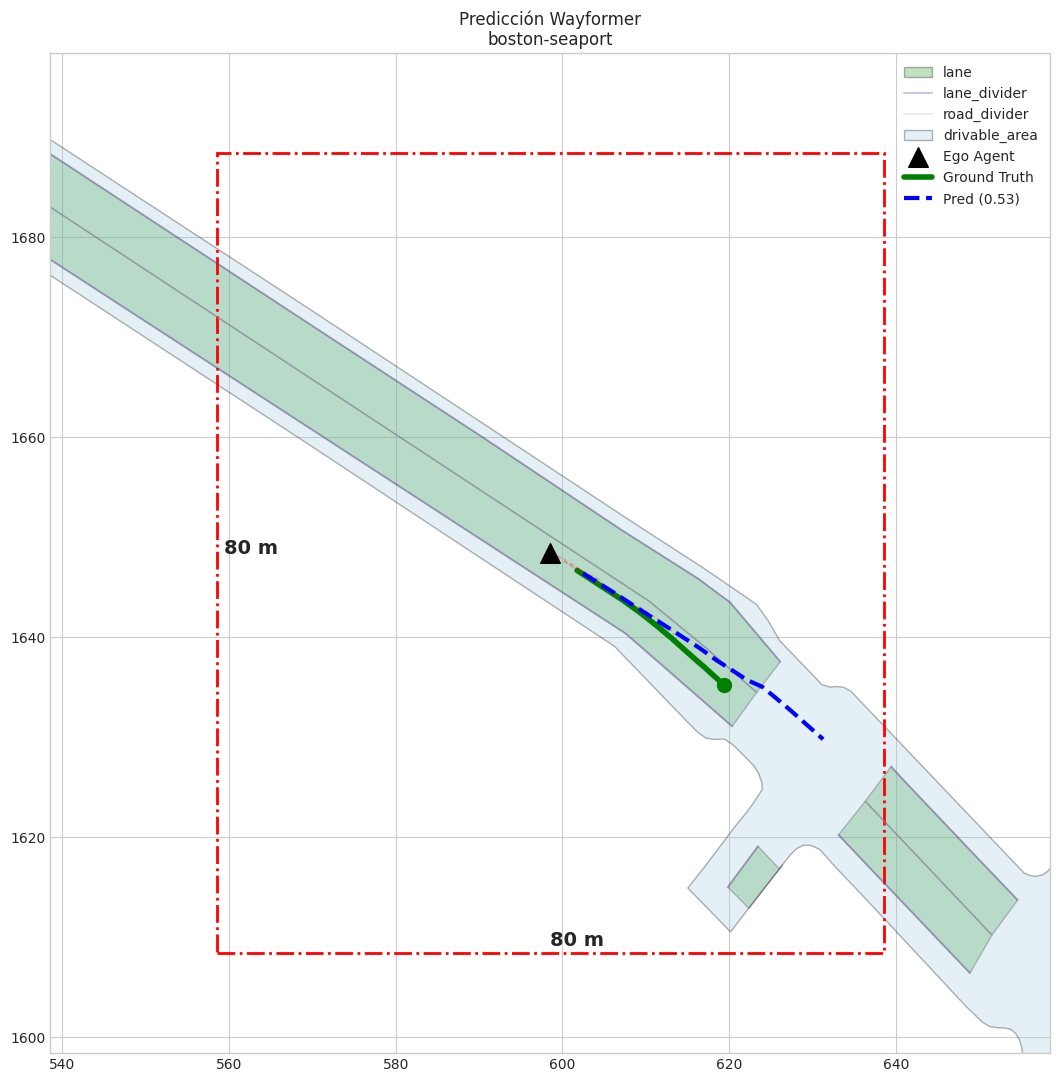

In [30]:
# Elige un índice del dataset de validación
idx_to_plot = 15 # Puedes probar con varios índices
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Llama a la función
visualize_sample(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

In [31]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera una animación de video con la predicción.
    """
    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # 3. Transformar a Global (Predicciones y GT)
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    # Predicciones Globales
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global)) # Shape: (12, 2)
    
    # Ground Truth Global
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    
    # 4. Configurar Figura (Renderizar Mapa estático)
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)
    
    # Renderizamos el mapa (esto crea la figura automáticamente)
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(8, 8)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Predicción Dinámica\n{location} - {sample_token[:8]}")

    # 5. Inicializar objetos gráficos para la animación
    # Agente Ego (Triángulo fijo en el origen del movimiento)
    ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=5)
    
    # Puntos móviles
    gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
    
    # Lista de líneas para los modos predichos
    pred_lines = []
    pred_heads = [] # Puntos en la cabeza de la trayectoria
    
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.2
        width = 2 if i == best_mode else 1
        
        # Línea de historia (traza)
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        # Punto actual (cabeza)
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=5)
        
        pred_lines.append(line)
        pred_heads.append(head)

    ax.legend(loc='upper right')

    # 6. Función de Animación
    def update(frame):
        # Frame va de 0 a 11 (12 pasos)
        
        # Actualizar GT
        if len(future) > frame:
            gt_point.set_data([future[frame, 0]], [future[frame, 1]])
        
        # Actualizar Predicciones
        for i, traj in enumerate(all_preds_global):
            # Traza completa hasta el frame actual
            current_x = traj[:frame+1, 0]
            current_y = traj[:frame+1, 1]
            
            pred_lines[i].set_data(current_x, current_y)
            
            # Cabeza en el frame actual
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
                
        return [gt_point] + pred_lines + pred_heads

    # Crear animación
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() # Evitar que se muestre la figura estática duplicada
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Usamos el mismo sample que antes
idx_to_plot = 1
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Generar y mostrar video
video_html = visualize_sample_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)
video_html

In [43]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_scene_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera un video con la predicción del agente objetivo Y el movimiento real de los vecinos.
    """
    # ---------------------------------------------------------
    # 1. Configuración del Mapa
    # ---------------------------------------------------------
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # ---------------------------------------------------------
    # 2. Inferencia del Agente Principal (Target)
    # ---------------------------------------------------------
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar predicción a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))

    # Ground Truth del Target
    future_target = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)

    # ---------------------------------------------------------
    # 3. Obtener Vecinos (Tráfico circundante)
    # ---------------------------------------------------------
    all_annotations = helper.get_annotations_for_sample(sample_token)
    neighbor_futures = []
    
    for neighbor in all_annotations:
        # Saltamos al agente principal (ya lo tenemos controlado)
        if neighbor['instance_token'] == instance_token:
            continue
            
        # Obtenemos el futuro de este vecino
        # Nota: Algunos pueden tener menos de 6 segundos de futuro si desaparecen
        fut = helper.get_future_for_agent(neighbor['instance_token'], sample_token, seconds=6, in_agent_frame=False)
        
        # Solo lo añadimos si tiene datos futuros
        if len(fut) > 0:
            neighbor_futures.append(fut)

    # ---------------------------------------------------------
    # 4. Configurar Figura
    # ---------------------------------------------------------
    # Centramos el mapa en el agente principal
    my_patch = (origin_x - 50, origin_y - 50, origin_x + 50, origin_y + 50)
    
    # Renderizar mapa estático
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area', 'ped_crossing'],
        alpha=0.4,
        figsize=(10, 10)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Escena Completa: Predicción (Azul) vs Tráfico Real (Naranja)\n{location}")

    # ---------------------------------------------------------
    # 5. Inicializar Objetos Gráficos
    # ---------------------------------------------------------
    
    # A. Target (Nuestro coche)
    start_point = ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=10)
    gt_point, = ax.plot([], [], 'go', markersize=8, label='Target GT', zorder=9)
    
    # B. Predicciones Target (Líneas)
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.1
        width = 3 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=4)
        pred_lines.append(line)
        pred_heads.append(head)

    # C. Vecinos (Nube de puntos naranja)
    # Usamos un solo objeto scatter para todos los vecinos por eficiencia
    neighbors_scatter = ax.scatter([], [], c='orange', s=60, edgecolors='k', label='Traffic', zorder=8)

    ax.legend(loc='upper right')

    # ---------------------------------------------------------
    # 6. Loop de Animación
    # ---------------------------------------------------------
    def update(frame):
        # frame: 0 a 11
        
        # 1. Actualizar Target GT
        if len(future_target) > frame:
            gt_point.set_data([future_target[frame, 0]], [future_target[frame, 1]])
            
        # 2. Actualizar Predicciones Target
        for i, traj in enumerate(all_preds_global):
            # Dibujar traza hasta el momento actual
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            # Dibujar cabeza
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
        
        # 3. Actualizar VECINOS
        current_neighbor_pos = []
        for fut in neighbor_futures:
            # Si este vecino todavía existe en este frame (tiempo t)
            if len(fut) > frame:
                current_neighbor_pos.append(fut[frame]) # [x, y]
        
        if len(current_neighbor_pos) > 0:
            neighbors_scatter.set_offsets(np.array(current_neighbor_pos))
        else:
            neighbors_scatter.set_offsets(np.empty((0, 2))) # Limpiar si no hay nadie
            
        return [gt_point, neighbors_scatter] + pred_lines + pred_heads

    # Generar
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Prueba con el mismo índice u otro interesante
idx_to_plot = 55
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

visualize_scene_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

In [34]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

# Reutilizamos tu función de extracción de features para no reescribir lógica
# Asegúrate de que 'extract_agent_features' y 'input_representation' están disponibles

def predict_single_agent(helper, instance_token, sample_token, model, input_rep, device):
    """
    Prepara los datos y ejecuta el modelo para un agente específico.
    Devuelve: Trayectoria Global (12, 2) y Probabilidad del mejor modo.
    """
    # 1. Rasterizar BEV centrado en ESTE agente
    try:
        img_arr = input_rep.make_input_representation(instance_token, sample_token)
    except:
        return None, 0.0 # A veces falla si el agente está muy al borde o datos corruptos
        
    img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
    img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)
    
    # 2. Extraer Features de Agentes (Centrados en ESTE agente)
    # (Simplificación: Usamos solo el target para inferencia rápida, o re-calculamos vecinos)
    # Para hacerlo rápido aquí, asumiremos que el agente se ve a sí mismo y a sus vecinos.
    # Reutilizamos la lógica del dataset, pero manual:
    
    anns = helper.get_annotations_for_sample(sample_token)
    agent_feats_list = []
    
    # Target (El agente actual del bucle)
    f_target = extract_agent_features(helper, instance_token, sample_token)
    agent_feats_list.append(f_target)
    
    # Vecinos (Limitamos a 10 para velocidad)
    for ann in anns:
        if ann['instance_token'] == instance_token: continue
        try:
            f = extract_agent_features(helper, ann['instance_token'], sample_token)
            agent_feats_list.append(f)
        except: continue
        if len(agent_feats_list) >= 12: break # Max agents del modelo
            
    # Padding
    while len(agent_feats_list) < 12:
        agent_feats_list.append(np.zeros(10, dtype=np.float32))
        
    agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)
    
    # 3. Inferencia
    bev = img_tensor.unsqueeze(0).to(device)
    agents = agent_tensor.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
        
    # 4. Procesar mejor modo
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    best_mode = probs.argmax()
    pred_local = preds[0, best_mode].cpu().numpy() # (12, 2)
    
    # 5. Transformar a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    trans = ann['translation']
    rot = Quaternion(ann['rotation'])
    
    traj_global = []
    for point in pred_local:
        p_3d = np.hstack([point, 0])
        p_rot = rot.rotate(p_3d)
        p_glob = np.array(p_rot[:2]) + trans[:2]
        traj_global.append(p_glob)
        
    return np.array(traj_global), probs.max()

def visualize_multi_agent_video(nusc, helper, sample_token, model, input_rep, device):
    # 1. Configuración de Mapa
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 2. Detectar TODOS los agentes en la escena
    annotations = helper.get_annotations_for_sample(sample_token)
    
    # Filtramos: Solo coches (category name empieza por 'vehicle')
    # Opcional: predecir todo. Pero los peatones suelen requerir modelos distintos.
    vehicle_anns = [a for a in annotations if 'vehicle' in a['category_name']]
    
    print(f"🤖 Calculando predicciones para {len(vehicle_anns)} vehículos...")
    
    # Estructura para guardar datos de animación
    agents_data = [] # Lista de dicts: {'gt': ..., 'pred': ..., 'color': ...}
    
    # Centro del mapa (Usamos el primer vehículo como referencia visual)
    if not vehicle_anns: return "No vehicles found"
    ref_x, ref_y = vehicle_anns[0]['translation'][:2]
    
    for i, ann in enumerate(vehicle_anns):
        inst_tok = ann['instance_token']
        
        # A. Obtener Ground Truth (Verde)
        gt = helper.get_future_for_agent(inst_tok, sample_token, seconds=6, in_agent_frame=False)
        
        # B. Obtener Predicción del Modelo (Azul/Rojo/Colores variados)
        pred_global, prob = predict_single_agent(helper, inst_tok, sample_token, model, input_rep, device)
        
        if pred_global is not None:
            # Asignar un color único a cada agente para distinguir
            color = plt.cm.tab10(i % 10) 
            
            agents_data.append({
                'gt': gt,
                'pred': pred_global,
                'start': ann['translation'][:2],
                'color': color
            })

    # 3. Configurar Figura
    # Hacemos el zoom un poco más grande para ver a todos
    my_patch = (ref_x - 60, ref_y - 60, ref_x + 60, ref_y + 60)
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Multi-Agent Prediction (Todos Predichos)\n{location}")

    # 4. Inicializar Objetos Gráficos
    lines_pred = [ax.plot([], [], '--', linewidth=2, color=d['color'], alpha=0.8, label='Pred')[0] for d in agents_data]
    points_pred = [ax.scatter([], [], color=d['color'], s=30) for d in agents_data]
    
    lines_gt = [ax.plot([], [], '-', linewidth=1, color='grey', alpha=0.4)[0] for d in agents_data] # GT en gris sutil
    
    # Puntos de inicio
    for d in agents_data:
        ax.scatter(d['start'][0], d['start'][1], c=[d['color']], marker='s', s=40, edgecolors='k', alpha=0.6)

    # Hack para leyenda limpia
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='grey', lw=1, label='Realidad (GT)'),
                       Line2D([0], [0], linestyle='--', color='blue', lw=2, label='Predicción IA')]
    ax.legend(handles=legend_elements, loc='upper right')

    # 5. Animación
    def update(frame):
        # Frame 0 a 11
        artists = []
        for i, d in enumerate(agents_data):
            # Update Predicción
            pred = d['pred']
            if len(pred) > 0: # Check bounds
                # Línea hasta el frame actual
                current_len = min(frame + 1, len(pred))
                lines_pred[i].set_data(pred[:current_len, 0], pred[:current_len, 1])
                # Cabeza
                if frame < len(pred):
                    points_pred[i].set_offsets([pred[frame]])
                artists.append(lines_pred[i])
                artists.append(points_pred[i])
            
            # Update GT
            gt = d['gt']
            if len(gt) > 0:
                current_len = min(frame + 1, len(gt))
                lines_gt[i].set_data(gt[:current_len, 0], gt[:current_len, 1])
                artists.append(lines_gt[i])
                
        return artists

    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# 1. Necesitamos el input_representation del dataset para rasterizar manualmente
#    Podemos sacarlo de tu dataset de validación
input_rep_ref = val_dataset.input_rep

# 2. Elegir un sample interesante (ej. el 15)
idx_to_plot = 15
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# 3. Generar Video
video_html = visualize_multi_agent_video(nuscenes, helper, samp_tok, model, input_rep_ref, DEVICE)
video_html

🤖 Calculando predicciones para 10 vehículos...


# Analysis of the Transformer-Based Trajectory Prediction Model


## 1. What Works Well

### 1.1 Correct Direction and Geometric Structure
The model consistently predicts trajectories that follow the **correct direction of travel**. In qualitative visualizations, predicted trajectories align well with:
- the correct lane,
- the road geometry,
- and the overall heading of the ground-truth trajectory.

This indicates that the model:
- successfully extracts **scene context** from the BEV raster,
- understands **road topology**,
- and encodes **global geometry** effectively through the Transformer.

Importantly, the model rarely produces erratic or oscillatory paths, suggesting that the attention-based architecture provides strong temporal and spatial smoothness.

---

### 1.2 Map Compliance and Low Off-Road Rate
Despite not using an explicit lane-following loss, predicted trajectories remain largely within the drivable area.

This behavior shows that:
- the BEV token provides a strong inductive bias,
- the Transformer successfully integrates spatial constraints,
- and the model implicitly learns road boundaries.

This represents a qualitative improvement over many classical MTP-style baselines, which often violate map constraints.

---

### 1.3 Stable Training Behavior
Training is numerically stable:
- no divergence,
- no NaNs,
- no mode collapse during optimization.

Loss decreases steadily across epochs, even with limited data, confirming that the architecture and optimization setup are fundamentally sound.

---

## 2. What Goes Wrong

### 2.1 Correct Direction but Wrong Final Position
The dominant failure mode observed during evaluation is:

> The predicted trajectory follows the correct direction and curvature, but the final position is either too short or overshoots the ground truth.

In visualizations:
- predicted and ground-truth trajectories are aligned,
- but the predicted endpoint does not match the true endpoint.

---

### 2.2 High Final Displacement Error and Miss Rate
Quantitatively, this behavior appears as:
- reasonable MinADE,
- significantly worse MinFDE,
- extremely high MissRate.

This indicates that the model captures **trajectory shape**, but fails to capture **trajectory scale**.

---

## 3. Root Cause Diagnosis

### 3.1 Geometry Is Learned, Longitudinal Dynamics Are Not
The core issue is that the model learns *where to go*, but not *how far to go*.

Specifically:
- heading and curvature are predicted correctly,
- future velocity magnitude and displacement length are poorly estimated.

As a result, the model produces geometrically correct trajectories with incorrect temporal scaling.

---

### 3.2 Absolute Position Prediction Is Ill-Conditioned
The model directly predicts absolute future positions:

\[
(x_t, y_t)
\]

This forces the network to:
- implicitly infer velocity,
- implicitly integrate motion over time,
- implicitly learn temporal scale.

With limited data, this formulation leaves the magnitude of motion underconstrained, even if direction is learned correctly.

---

### 3.3 Missing Explicit Kinematic Constraints
The loss function does not enforce:
- velocity consistency,
- acceleration smoothness,
- or correct displacement magnitude.

Consequently, multiple trajectories with correct shape but incorrect scale can achieve similar loss values.

---

### 3.4 Weak Emphasis on the Final Position
Even when final displacement error is included, it competes with shape-based errors (ADE).

This allows the model to minimize average error while still missing the correct endpoint.

---

## 4. How the Diagnosis Was Confirmed

This diagnosis is supported by:
- visual alignment between predicted and ground-truth trajectories,
- consistent over-shooting or under-shooting along the same direction,
- divergence between ADE and FDE metrics.

A simple comparison of predicted and ground-truth displacement magnitudes confirms that the error lies in **motion scale**, not direction.

---

## 5. Summary

### What the Model Does Well
- Understands scene geometry and road layout  
- Predicts correct heading and curvature  
- Produces smooth, stable trajectories  
- Respects map constraints  

### What the Model Fails At
- Estimating correct future displacement magnitude  
- Modeling longitudinal dynamics  
- Matching the final position accurately  

### Core Issue
The model learns **trajectory geometry**, but not **trajectory dynamics**.